In [1]:
import scipy.stats as stats
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
xlsx_path = '/content/drive/MyDrive/Учеба IT/AB-testingGB/Seminar8/AB_Test_Results_Copy.xlsx'
# !gdown --id file_URI
data = pd.read_excel(xlsx_path)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
data

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [ ]:
a_visits = data[data['VARIANT_NAME'] == 'control']
unique_users_control_group = a_visits['USER_ID'].unique().shape[0]
print(unique_users_control_group)
b_visits = data[data['VARIANT_NAME'] == 'variant']
unique_users_variant_group = b_visits['USER_ID'].unique().shape[0]
print(unique_users_variant_group)

3931
3934


In [ ]:
data.VARIANT_NAME.value_counts() # неверные данные, по-видимому, USER_ID дублируются в многих строках

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [ ]:
# Подготовим два массива, очистим их от выбросов, коими считаем единичные видимые глазом отклонения от медианы.
a_revenues_per_unique_user = a_visits.groupby('USER_ID').REVENUE.sum()
b_revenues_per_unique_user = b_visits.groupby('USER_ID').REVENUE.sum()

control_data_array = a_revenues_per_unique_user[(a_revenues_per_unique_user > 0) & (a_revenues_per_unique_user < 35)]
test_data_array = b_revenues_per_unique_user[(b_revenues_per_unique_user > 0) & (b_revenues_per_unique_user < 35)]

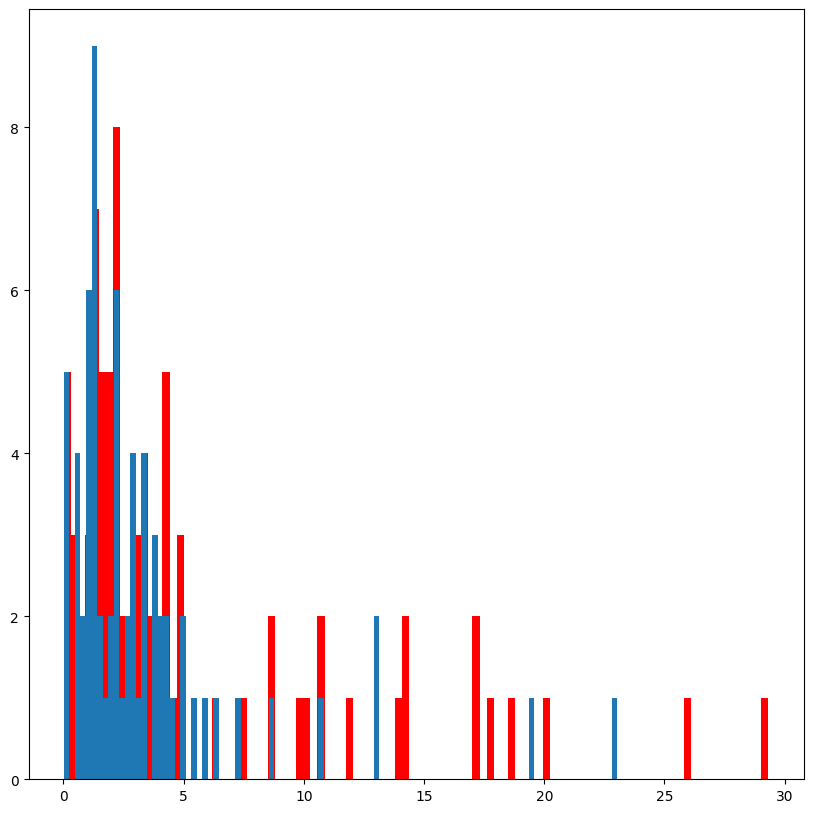

In [ ]:
# Предположу, что это не нормальное распределение (логично, что в бесплатном приложении количество юзеров уменьшается по мере того, как возрастает сумма, что эти юзеры платят) или я неправильно понимаю суть термина
plt.figure(figsize=(10, 10))
plt.hist(control_data_array, color='r', bins=100)
plt.hist(test_data_array,  bins=100);

In [ ]:
from scipy.stats import shapiro

In [ ]:
alpha = 0.05

st = shapiro(data.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st.pvalue < alpha]));

Distribution is not normal



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# Отвергаем нулевую гипотезу, рекомендуем продакт-менеджеру переносить тестируемые изменения на всех пользователей
stat, p = stats.ttest_ind(control_data_array, test_data_array, equal_var = False)

print('stat=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Groups are different (reject H0)')
else:
    print('Groups are similar (fail to reject H0)')

stat=2.091, p=0.038
Groups are different (reject H0)
